In [1]:
import pandas as pd
import random
import sys
from matplotlib import pyplot as plt
sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage
from model.amm.global_state import GlobalState, fluctuate_prices

# same seed, same parameters = same simulation result
random.seed(42)

price_dict = {
    'HDX': 0.05,
    'USD': 1,
    'LRNA': 0.5,
    'R1': 2,
    'R2': 2/3
}

def lrna_price(asset: str):
    return price_dict['LRNA'] / price_dict[asset]

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                'HDX': {'liquidity': 1000000, 'LRNA_price': lrna_price('HDX')},
                'USD': {'liquidity': 1000000, 'LRNA_price': lrna_price('USD')},
                'R1': {'liquidity': 1000000, 'LRNA_price': lrna_price('R1')},
                'R2': {'liquidity': 3000000, 'LRNA_price': lrna_price('R2')},
            },
            lrna_fee=0,
            asset_fee=0
        )
    },
    agents = {
        'Arbitrageur': Agent(
            holdings={'HDX': 1000000, 'USD': 1000000, 'R1': 1000000, 'R2': 3000000},
            trade_strategy=omnipool_arbitrage(
                pool_id='omnipool'
            )
        )
    },
    evolve_function=fluctuate_prices(volatility={'R1': 1, 'R2': 1}, trend={'R1': 1, 'R2': 1}),
    external_market=price_dict
)

time_steps = 5000
events = run.run(initial_state, time_steps=time_steps)

events = processing.postprocessing(events, optional_params=['withdraw_val'])

Starting simulation...
Execution time: 1.076 seconds.


<AxesSubplot:title={'center':'asset price: R2   '}>

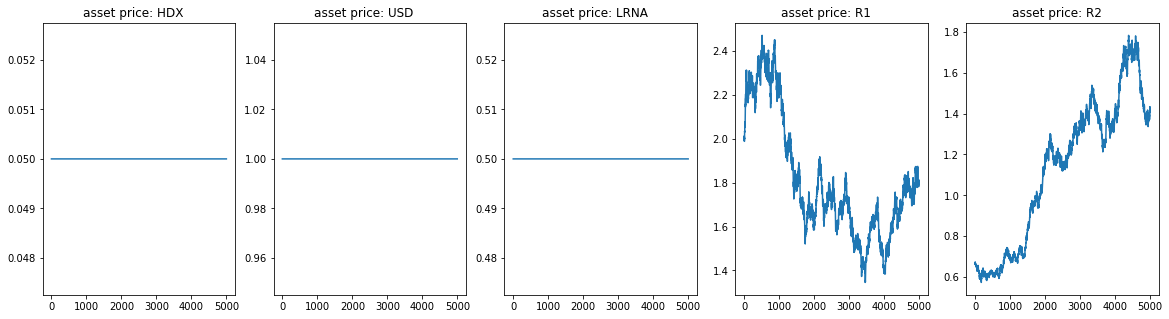

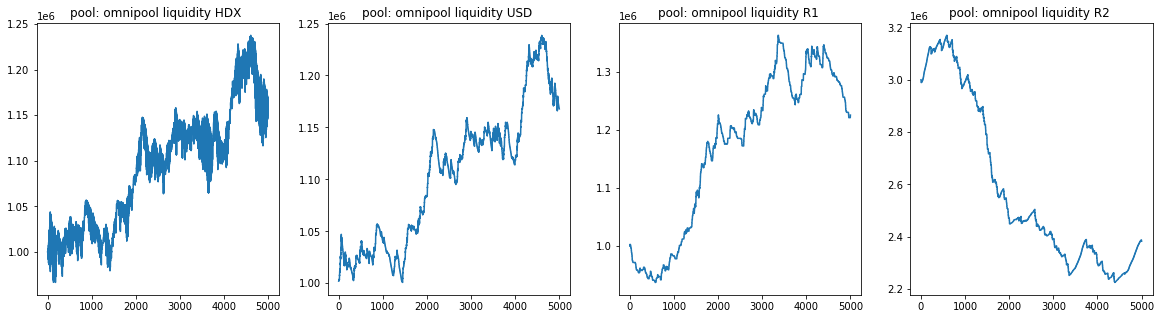

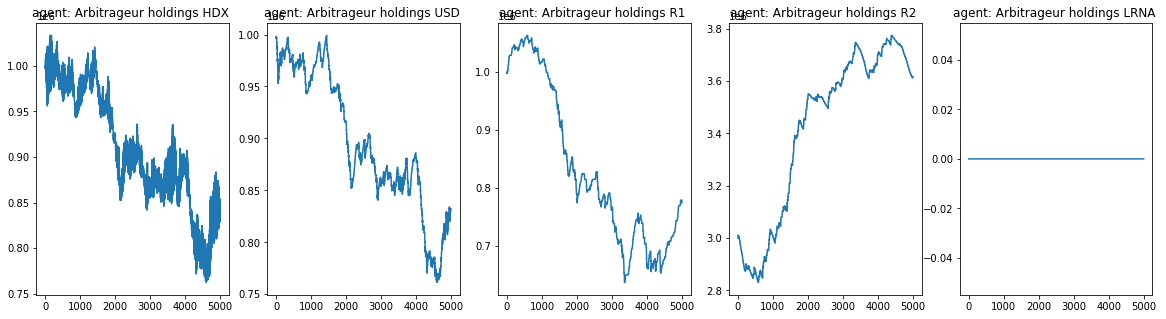

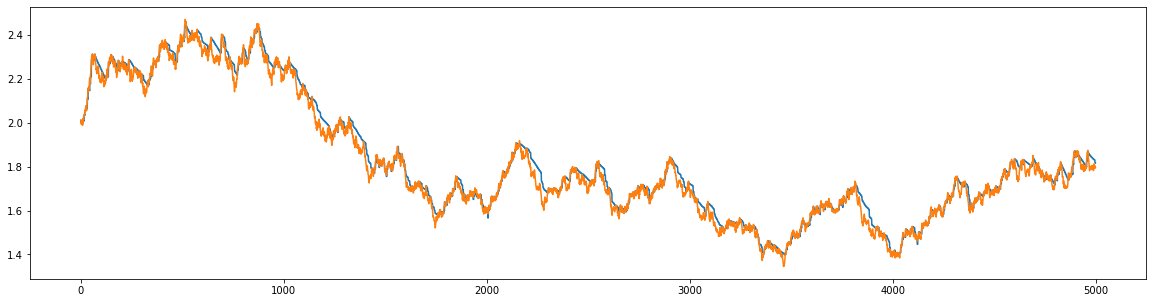

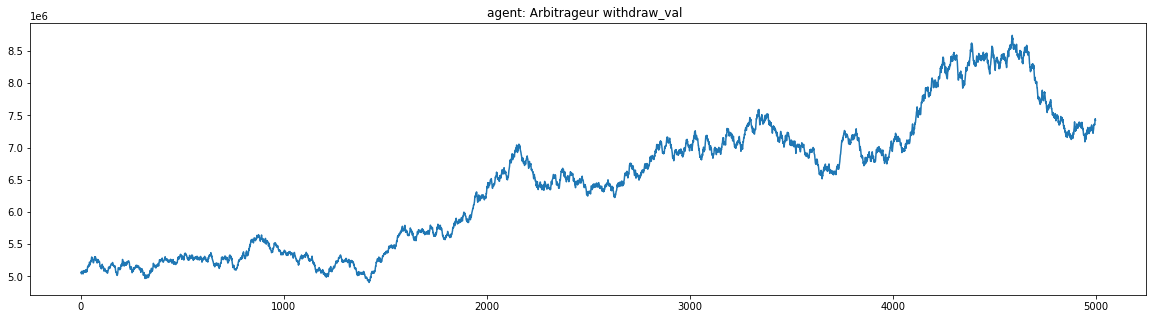

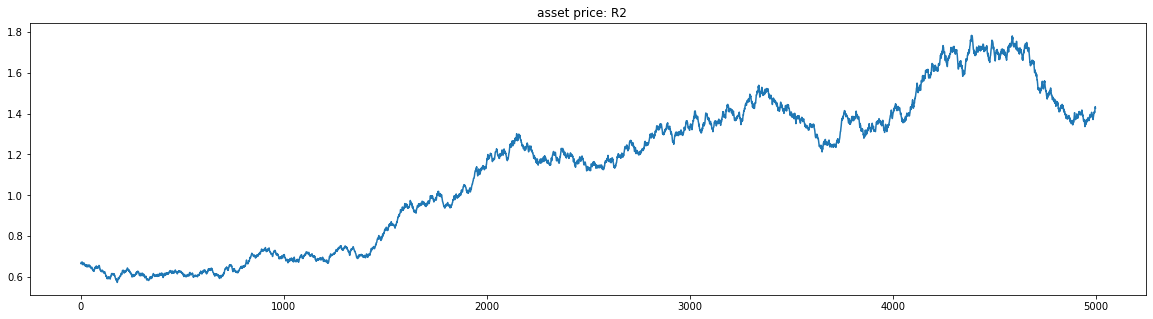

In [3]:
pu.plot(events, asset='all')
pu.plot(events, pool='omnipool', prop='liquidity')
lrna_price_in_usd = [event['state'].pools['omnipool'].liquidity['USD'] / event['state'].pools['omnipool'].lrna['USD'] for event in events]
R1_pool_price_usd = [event['state'].pools['omnipool'].lrna['R1'] * lrna_price_in_usd[i] / event['state'].pools['omnipool'].liquidity['R1'] for i, event in enumerate(events)]
pu.plot(events, agent='Arbitrageur', prop='holdings')
plt.figure(figsize=(20, 5))
plt.plot(range(time_steps), R1_pool_price_usd)
plt.plot(range(time_steps), pu.get_datastream(events, asset='R1'))
pu.plot(events, agent='Arbitrageur', prop='withdraw_val')
pu.plot(events, asset='R2')